In [20]:
import nbimporter
import networkx as nx
import random
from matplotlib import pyplot as plt
from brute_force import brute_force
from functools import wraps
import time

In [21]:
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        print(f"{func.__name__} took {end - start:.6f} seconds")
        return result
    return wrapper

In [22]:
def initialize(G, terminals):
    subgraph = G.subgraph(terminals)
    
    if not nx.is_connected(subgraph):
        H = nx.Graph()
    
        for u in terminals:
            for v in terminals:
                if u != v:
                    path = nx.shortest_path(G, u, v, weight="weight")
                    nx.add_path(H, path)
        subgraph = H
    
    best_tree = nx.minimum_spanning_tree(subgraph, weight="weight")
    best_w = best_tree.size(weight="weight")
    best_nodes = set(best_tree.nodes())

    return best_tree, best_w, best_nodes


In [49]:
@timeit
def tabu_search(G, terminals, iterations, tabu_size):
    current_tree, current_w, current_nodes = initialize(G, terminals)
    best_tree, best_w, best_nodes = current_tree, current_w, current_nodes
    
    nodes = list(set(G.nodes()) - set(terminals))
    tabu_list = []

    for _ in range(iterations):
        neighborhood = []
        
        for v in nodes:
            new_nodes = current_nodes | {v}
            subgraph = G.subgraph(new_nodes)
            if nx.is_connected(subgraph):
                T = nx.minimum_spanning_tree(subgraph, weight = "weight")
                w = T.size(weight = "weight")
                neighborhood.append((T, w, new_nodes, ("add", v)))

        for v in current_nodes - set(terminals):
            new_nodes = current_nodes - {v}
            subgraph = G.subgraph(new_nodes)
            if nx.is_connected(subgraph):
                T = nx.minimum_spanning_tree(subgraph, weight = "weight")
                w = T.size(weight = "weight")
                neighborhood.append((T, w, new_nodes, ("remove", v)))

        neighborhood = [n for n in neighborhood if n[3] not in tabu_list]
        if len(neighborhood) == 0:
            break

        candidate = min(neighborhood, key = lambda x: x[1])
        current_tree, current_w, current_nodes, move = candidate

        tabu_list.append(move)
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)

        if current_w < best_w:
            best_tree, best_w, best_nodes = current_tree, current_w, current_nodes

    return best_tree, best_w

In [24]:
K5 = nx.Graph()
edgesK5 = [
    (0, 1, 28), (0, 2, 13), (0, 3, 13), (0, 4, 22),
    (1, 2, 27), (1, 3, 28), (1, 4, 13),
    (2, 3, 19), (2, 4, 14),
    (3, 4, 19)
]
K5.add_weighted_edges_from(edgesK5)

In [25]:
K5best = nx.Graph()
edgesK5best = [
    (0, 1, 18), (0, 2, 20), (0, 3, 22), (0, 5, 10), (0, 6, 32), (0, 7, 29),
    (1, 2, 12), (1, 3, 18), (1, 4, 20), (1, 5, 29), (1, 6, 36), (1, 7, 10),
    (2, 3, 40), (2, 4, 20), (2, 5, 22), (2, 6, 21), (2, 7, 23),
    (3, 4, 22), (3, 5, 22), (3, 6, 40), (3, 7, 22),
    (4, 5, 23), (4, 6, 32), (4, 7, 20),
    (5, 6, 21), (5, 7, 33),
    (6, 7, 11)
]
K5best.add_weighted_edges_from(edgesK5best)

In [26]:
CS4234_2 = nx.Graph()
edgesCS4234_2 = [
    (0, 1, 14), (0, 3, 14), (0, 6, 8),
    (1, 2, 14), (1, 6, 14),
    (2, 3, 14), (2, 4, 10), (2, 5, 8),
    (3, 5, 8),
    (4, 2, 10),
    (5, 6, 6),
    (6, 0, 8)
]
CS4234_2.add_weighted_edges_from(edgesCS4234_2)

tabu_search took 0.006160 seconds


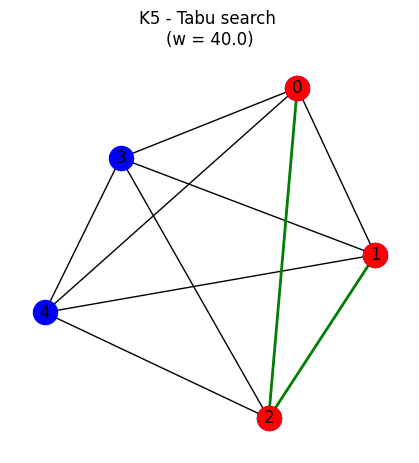

tabu_search took 0.077309 seconds


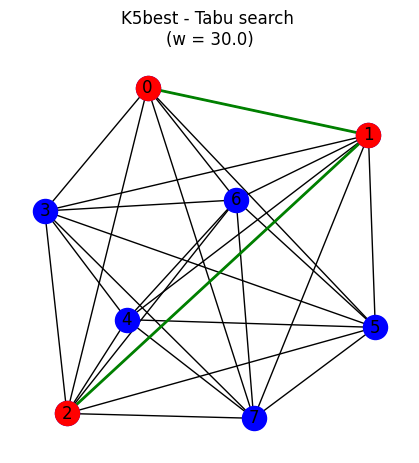

tabu_search took 0.052969 seconds


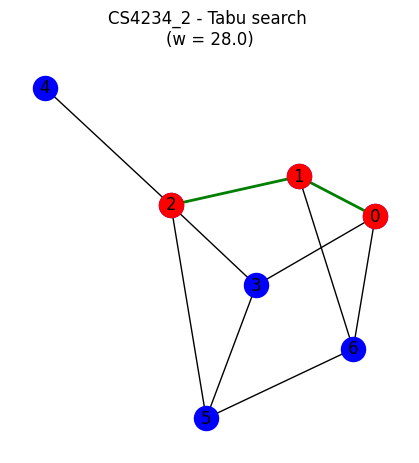

In [50]:
GS = [K5, K5best, CS4234_2]
names = ["K5", "K5best", "CS4234_2"]
terminals = [0,1,2]
for G, name in zip(GS, names): 
    pos = nx.spring_layout(G, seed = 42)
    T, w = tabu_search(G, terminals, 100, 5)
    
    plt.figure(figsize = (4,4))
    nx.draw(G, pos, with_labels = True, node_color = 'blue')
    nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
    nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
   # edge_labels = nx.get_edge_attributes(G, "weight") 
   # nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

    plt.title(f"{name} - Tabu search \n(w = {w})")
    plt.show()

In [51]:
def read_stp(filename):
    G = nx.Graph()
    terminals = set()
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('E'):
                parts = line.split()
                u, v, w = int(parts[1]), int(parts[2]), int(parts[3])
                G.add_edge(u, v, weight = w)
            elif line.startswith('T'):
                terminals.add(int(line.split()[1]))
                
    return G, terminals

In [52]:
G, terminals = read_stp('hc6u.stp')

tabu_search took 4.296476 seconds


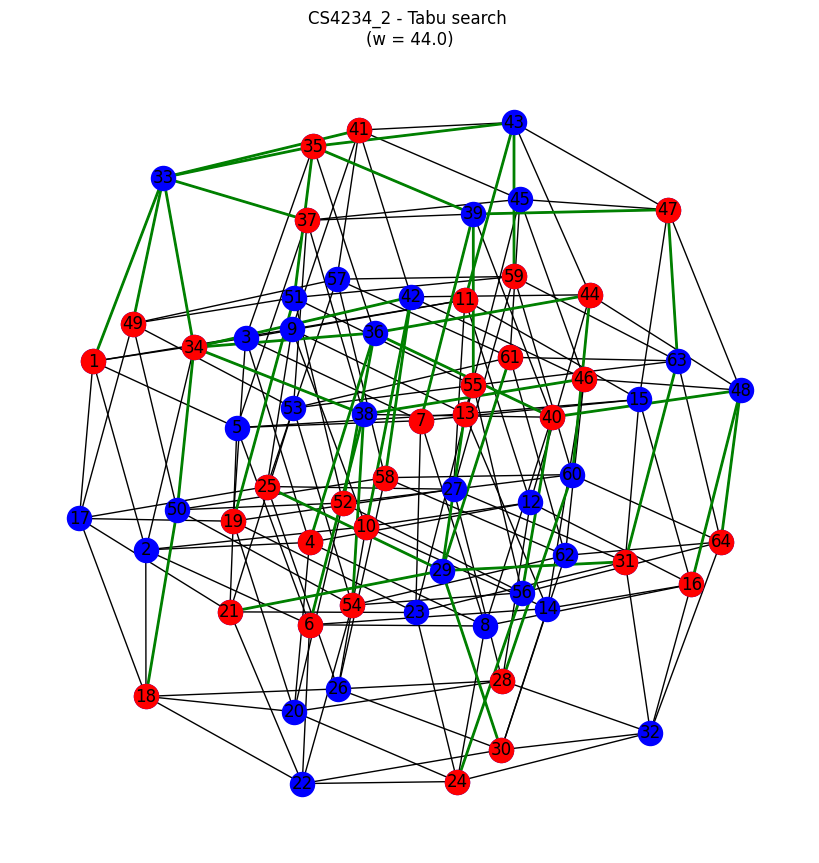

In [53]:
pos = nx.spring_layout(G, seed = 42)
T, w = tabu_search(G, terminals, 100, 5)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
# edge_labels = nx.get_edge_attributes(G, "weight") 
# nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

plt.title(f"{name} - Tabu search \n(w = {w})")
plt.show()

tabu_search took 337.645058 seconds


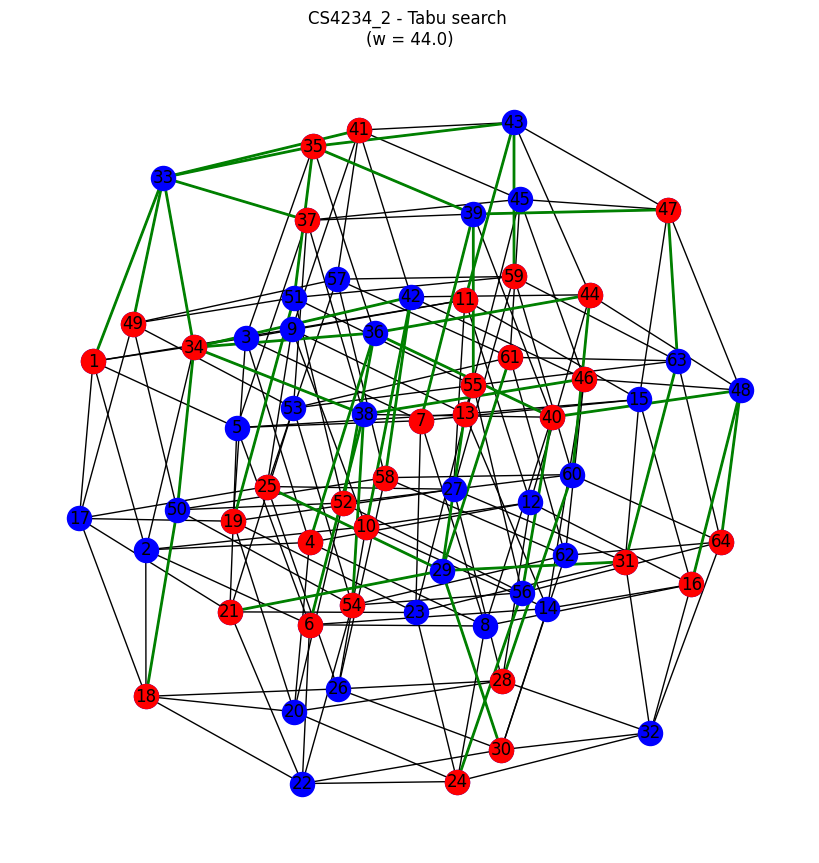

In [54]:
pos = nx.spring_layout(G, seed = 42)
T, w = tabu_search(G, terminals, 10000, 5)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
# edge_labels = nx.get_edge_attributes(G, "weight") 
# nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

plt.title(f"{name} - Tabu search \n(w = {w})")
plt.show()

tabu_search took 2877.768951 seconds


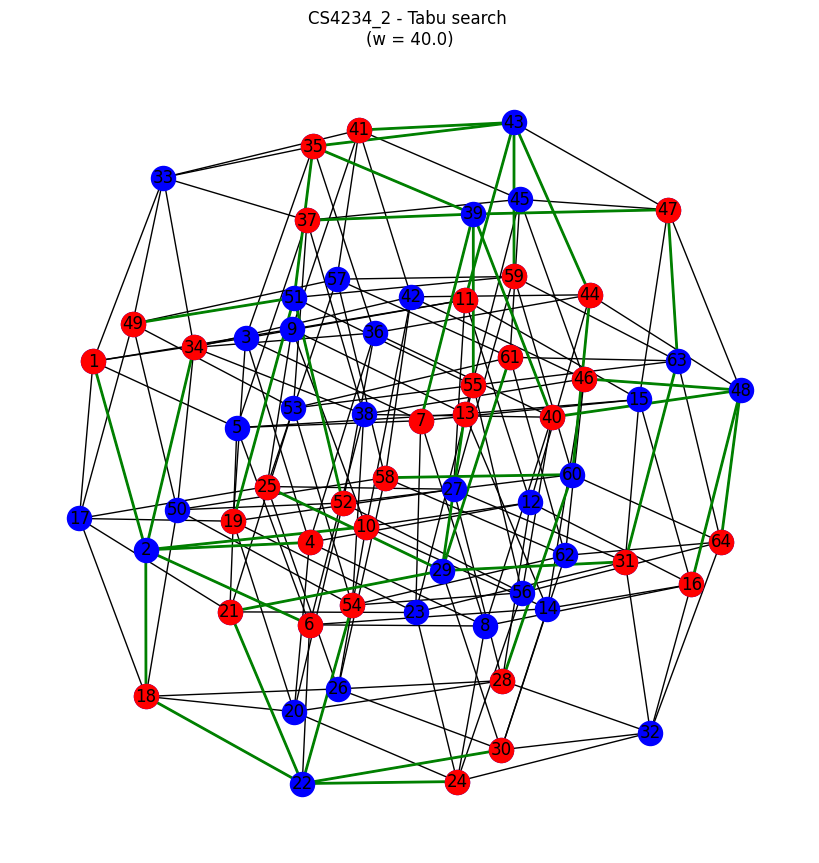

In [55]:
pos = nx.spring_layout(G, seed = 42)
T, w = tabu_search(G, terminals, 100000, 30)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
# edge_labels = nx.get_edge_attributes(G, "weight") 
# nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

plt.title(f"{name} - Tabu search \n(w = {w})")
plt.show()